# 0.Librerías

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

# 1. Clustering por producto

In [65]:
df = pd.read_csv(r"C:\Users\alici\Documents\master_data_science\proyecto_nuclio\TFM\datos_arreglados.csv", index_col=0)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

df.head()

,item,category,department,stores,region,week,year,is_holidays,units_sold,sell_price,total_sales
date,,,,,,,,,,,
2013-07-08,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,0,0,12.7414,0.0000
2013-07-15,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,1,0,12.7414,0.0000
2013-07-22,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,29,2013,0,4,10.9858,43.9432
2013-07-29,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,30,2013,0,6,10.9858,65.9148
2013-08-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,31,2013,0,0,10.9858,0.0000


Para realizar un clustering de productos similares, debemos centrarnos en las variables que describen mejor las características y el comportamiento de los productos. En este caso, las variables que podrían ser más útiles para un análisis de clustering son:

*-item:* Identificador del producto, que nos permitirá diferenciar cada uno de ellos.

*-category:* La categoría del producto es una característica fundamental que agrupa productos similares.

*-department:* Similar a la categoría, pero puede ser una clasificación más amplia dentro de la tienda.

*-units_sold:* La cantidad de unidades vendidas puede indicar la popularidad o la demanda del producto.

*-sell_price:* El precio de venta nos da una idea del segmento de mercado del producto (económico, premium, etc.).

*-total_sales:* Representa el ingreso total generado por el producto, que puede ser un reflejo de su éxito y su posición en el mercado.

Las variables como *date, week, year* y *is_holidays* son temporales y contextuales, y no necesariamente reflejan las propiedades intrínsecas de los productos. Sin embargo, podríamos incluir más adelante *is_holidays* puesto que la venta de ciertos productos puede estar fuertemente influenciada por temporadas festivas, lo que podría ayudar a identificar productos de temporada.

Vamos a intentar obtener un rendimiento histórico por producto para poder añadirlo al clustering.

### 1.1. Agregamos datos por producto

In [66]:
aggregated_data = df.copy()

In [67]:
# Agregamos datos para cada producto
aggregated_data = df.groupby('item').agg({
    'units_sold': ['mean', 'sum', 'std'],
    'sell_price': 'mean',
    'total_sales': 'mean',
    'is_holidays': 'sum'
}).reset_index()

# Aplanamos las columnas multindex para simplificar el índice en una sola capa
aggregated_data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in aggregated_data.columns.values]

# Renombramos las columnas para que tengan nombres más claros
# Cada fila corresponderá a un producto único y las columnas representarán las estadísticas agregadas de ese producto a lo largo del tiempo
aggregated_data.rename(columns={
    'units_sold_mean': 'avg_units_sold', # Promedio de unidades vendidas por producto
    'units_sold_sum': 'total_units_sold', # Total de unidades vendidas por producto
    'units_sold_std': 'std_units_sold', # Desviación de los datos. Un valor alto( gran dispersión), uno bajo(los datos son más consistentes). Podríamos compararlo con otros productos y con respecto a la media
    'sell_price_mean': 'avg_sell_price', # Precio de venta promedio del producto
    'total_sales_mean': 'avg_total_sales', # Promedio de ventas totales
    'is_holidays_sum': 'total_holiday_weeks' # Suma del número de veces que las ventas del producto ocurrieron durante una semana de vacaciones
}, inplace=True)

aggregated_data.round(2)

,item,avg_units_sold,total_units_sold,std_units_sold,avg_sell_price,avg_total_sales,total_holiday_weeks
0,ACCESORIES_1_001,2.78,4051,2.40,11.04,30.57,374
1,ACCESORIES_1_002,1.91,5047,2.23,5.28,10.10,656
2,ACCESORIES_1_003,1.25,1405,1.63,3.94,4.93,284
3,ACCESORIES_1_004,14.35,38996,13.13,5.98,86.17,679
4,ACCESORIES_1_005,5.63,14529,5.20,3.83,21.44,657
...,...,...,...,...,...,...,...
3044,SUPERMARKET_3_823,5.84,15290,9.87,3.34,19.29,661
3045,SUPERMARKET_3_824,3.03,8315,3.58,3.03,9.26,690
3046,SUPERMARKET_3_825,4.92,13465,5.55,4.93,23.94,686
3047,SUPERMARKET_3_826,7.67,12121,5.79,1.54,11.78,398


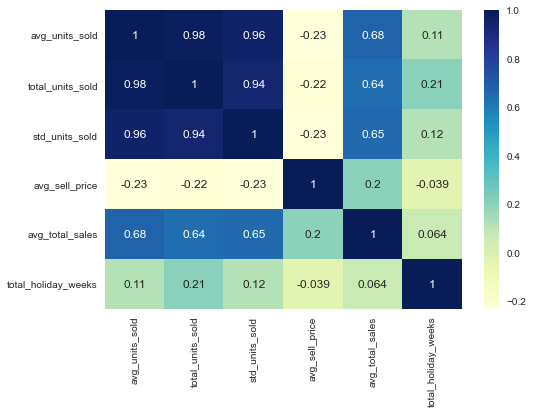

In [68]:
# Obtenemos la correlación de las diferentes variables
sns.heatmap(aggregated_data.corr(), annot=True, cmap="YlGnBu");

Procederemos a eliminar las variables que tengan una alta correlación entre sí para no añadirlas al modelo.

### 1.2. Preprocesamiento de datos

In [69]:
# Estandarizamos las características
scaler = StandardScaler()
features = aggregated_data.drop(['item',] axis=1)
features_scaled = scaler.fit_transform(features)

### 1.3. Modelo

In [70]:
k = 3 
# Inicializamos y ajustamos el modelo K-Means
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features_scaled)

# Asignamos los clusters a cada producto
aggregated_data['product_cluster'] = kmeans.labels_


c:\Users\alici\anaconda3\envs\Nuclio_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### 1.4. Resultados

In [71]:
# Mostramos los resultados
aggregated_data[['item', 'product_cluster']]

,item,product_cluster
0,ACCESORIES_1_001,0
1,ACCESORIES_1_002,1
2,ACCESORIES_1_003,0
3,ACCESORIES_1_004,1
4,ACCESORIES_1_005,1
...,...,...
3044,SUPERMARKET_3_823,1
3045,SUPERMARKET_3_824,1
3046,SUPERMARKET_3_825,1
3047,SUPERMARKET_3_826,0
